In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import kaggle

from operator import attrgetter
from datetime import timedelta

from datetime import datetime

- Импортируем данные с помощью API kaggle.

In [2]:
kaggle.api.authenticate()
kaggle.api.dataset_download_files('danilageraskin/project-2', path='.', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/danilageraskin/project-2


In [3]:
#таблица с уникальными идентификаторами пользователей
customers_df = pd.read_csv('olist_customers_dataset.csv')

In [4]:
#таблица заказов
orders_df = pd.read_csv('olist_orders_dataset.csv')

In [5]:
#уникальный идентификатор заказа (номер чека)
order_items_df = pd.read_csv('olist_order_items_dataset.csv')

### 1. Считаем сколько пользователей сделало только один заказ.

- Первое, что нужно сделать это объединить два датафрейма olist_customers_datase и olist_orders_dataset по customer_id. Это нужно сделать для того, чтобы считать кол-во заказов по customer_unique_id.

In [6]:
customer_unique_id_order_status = customers_df.merge(orders_df, on='customer_id')

- Общая информация.

In [7]:
print(f'1)Кол-во строк: {customer_unique_id_order_status.shape[0]}, кол-во столбцов: {customer_unique_id_order_status.shape[1]};')

print(f'2)Кол-во пропущенных значений: {customer_unique_id_order_status.isnull().sum().sum()};')

print(f'3)Дубликатов строк: {customer_unique_id_order_status.duplicated().sum()};')

1)Кол-во строк: 99441, кол-во столбцов: 12;
2)Кол-во пропущенных значений: 4908;
3)Дубликатов строк: 0;


- Далее выбирем людей, которые совершили покупку только один раз. Так же нужно определить по какому статутсу
можно считать, что заказ куплен. Будем считать, что если заказ доставлен пользователю, т.к. в любом из предыдущих
этапов пользователь сможет отменить заказ и он окажется в статусе отменен.

In [8]:
orders_delivered = customer_unique_id_order_status.query('order_status == "delivered"') \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_id':'count'}) \
    .sort_values(by=['order_id']) \
    .rename(columns={"order_id": "count_orders"})

In [9]:
print(orders_delivered.query('count_orders == 1').count_orders.sum() , 'ПОЛЬЗОВАТЕЛЕЙ СДЕЛАЛО ТОЛЬКО ОДИН ЗАКАЗ!')

90557 ПОЛЬЗОВАТЕЛЕЙ СДЕЛАЛО ТОЛЬКО ОДИН ЗАКАЗ!


### 2. Подсчитаем сколько заказов в месяц в среднем не доставляется по разным причинам и выведем детализацию по причинам.

In [10]:
customer_unique_id_order_status.query('order_status == "canceled"').head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
46,f34a6e874087ec1f0e3dab9fdf659c5d,233896de79986082f1f479f1f85281cb,38300,ituiutaba,MG,6e98de3a85c84ead6689189b825d35b5,canceled,2018-03-15 10:07:02,2018-03-15 10:29:33,NaN,NaN,2018-04-09 00:00:00
378,3ba47b09546c2da91ef141efce2d5888,b8c37ee810b38c416022e1c9f51e740c,32140,contagem,MG,a402af38a74c44926247db438245d95c,canceled,2018-01-30 22:12:10,2018-01-30 22:34:14,NaN,NaN,2018-03-06 00:00:00
380,cfffbb322333151f8df6398a8c3340db,0dc0731aafd5659410244092b0dc7d65,5093,sao paulo,SP,f63cd97f8f1db2eb266fb3bc2b4a95f3,canceled,2017-06-19 14:07:04,2017-06-19 14:23:18,NaN,NaN,2017-06-30 00:00:00
409,ffaded93e5a1fce06363cfb6905676a1,587b326ba3bf8aa4d3e50fb1f38ea79f,6722,cotia,SP,5bca61e411c4fcce08327a8efc371911,canceled,2018-06-13 20:52:10,2018-06-13 21:20:38,NaN,NaN,2018-07-11 00:00:00
878,c8223f76047e09bea798462f2f46ffa9,b4ee22e08cdaeab0b8e6bf2e67d7c19b,45690,una,BA,5b4858f2dcf69731f2285a38829bfa7c,canceled,2018-02-15 20:53:17,2018-02-15 21:06:43,2018-02-16 16:52:52,NaN,2018-03-16 00:00:00


- У нас нет точныз причин, почему пользователей отменил заказ, поэтому нужно самому понять почему некоторые заказы были отменены. Для себя я смог выделить три фактора:  
    1. Не устраивает дата обещанной доставки; 
    2. Не устраивает цена;
    3. Недоступен(unavailable).

Тут стоит смотреть не на итоговую цена, а на order_approved_at(время подтверждения оплаты заказа). *Пустая ли колонка или нет.
На самом деле тут нужно понять, когда клиент видет обещанную дату доставки. После оплаты или до, но т.к. у
меня нет такой информации — буду полагаться на свой опыт и считать, что клиент видет дату доставки после оплаты,
как это бывает на различных современных маркетплейсах(дата постоянна сдвигается). И получается если в колонке order_approved_at нет данных,
то буду считать, что клиенту не подходит цена. А если есть дата, то буду считать, что клиента не устраивает 
дата обещанной доставки.

- Для удобства создаю новый датафрейм и удалаю лишние столбцы.

In [11]:
count_orders_canceled_df = customer_unique_id_order_status

In [12]:
count_orders_canceled_df = count_orders_canceled_df.drop(['customer_id', 'customer_zip_code_prefix'], axis=1)

In [13]:
count_orders_canceled_df = count_orders_canceled_df.drop(['customer_city', 'customer_state', 'order_id'], axis=1)

- Преобразуем дату в удобный формат.

In [14]:
count_orders_canceled_df['order_purchase_timestamp'] = pd.to_datetime(count_orders_canceled_df['order_purchase_timestamp'])

count_orders_canceled_df['order_approved_at'] = pd.to_datetime(count_orders_canceled_df['order_approved_at'])

count_orders_canceled_df['order_delivered_carrier_date'] = pd.to_datetime(count_orders_canceled_df['order_delivered_carrier_date'])

count_orders_canceled_df['order_delivered_customer_date'] = pd.to_datetime(count_orders_canceled_df['order_delivered_customer_date'])

count_orders_canceled_df['order_estimated_delivery_date'] = pd.to_datetime(count_orders_canceled_df['order_estimated_delivery_date'])

- Выносим месяц и год отдельно, чтобы удобнее было визуализировать данные.

In [15]:
count_orders_canceled_df['month_start'] = pd.to_datetime(count_orders_canceled_df['order_purchase_timestamp'], dayfirst=True).dt.month

In [16]:
count_orders_canceled_df['years_start'] = pd.to_datetime(count_orders_canceled_df['order_purchase_timestamp'], dayfirst=True).dt.year

- Считаю разницу между моментом создания заказа и датой обещанной доставки.

In [17]:
count_orders_canceled_df['diff_start_end'] = \
   count_orders_canceled_df['order_estimated_delivery_date'] - count_orders_canceled_df['order_purchase_timestamp']

In [18]:
count_orders_canceled_df['diff_start_end'] = count_orders_canceled_df.diff_start_end.dt.days

- Проверим, что отрицательных элементов в diff_start_end нет.

In [19]:
count_orders_canceled_df.query('diff_start_end < 0').count().sum()

0

- Заменяю пропущенные значения в столбце подтверждения оплаты заказа(order_approved_at).

In [20]:
count_orders_canceled_df.order_approved_at = count_orders_canceled_df.order_approved_at.fillna('Не устраивает цена')

- Датафрейм, где не устраивает цена.

In [21]:
because_of_the_price_df = count_orders_canceled_df.query('order_approved_at == "Не устраивает цена" and order_status == "canceled"')

In [22]:
because_of_the_price_df.shape

(141, 10)

- Датафрейм, где не устраивает дата доставки.

In [23]:
because_of_the_delivery_df = count_orders_canceled_df.query('order_approved_at != "Не устраивает цена" and order_status == "canceled"')

In [24]:
because_of_the_delivery_df.shape

(484, 10)

- Датафрейм, где заказ недоступен.

In [25]:
unavailable_df = count_orders_canceled_df.query('order_status == "unavailable"')

In [26]:
unavailable_df.shape

(609, 10)

- График отмененных заказов из-за цены в 2017 году.

[Text(0.5, 1.0, 'График отмененных заказов из-за цены в 2017 году'),
 Text(0.5, 0, '№ месяца'),
 Text(0, 0.5, 'Кол-во')]

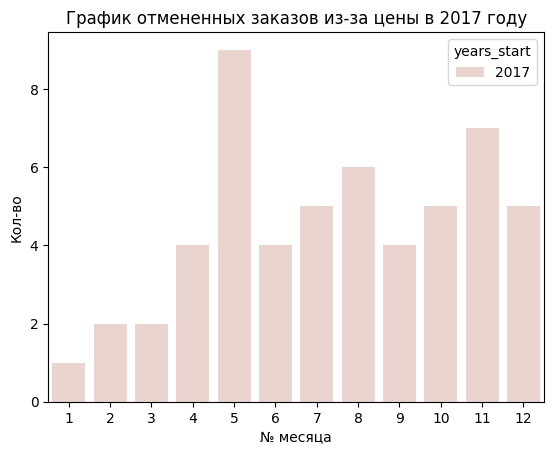

In [27]:
sns.countplot(x ='month_start', hue = "years_start", data = because_of_the_price_df.query('years_start == 2017')) \
    .set(title='График отмененных заказов из-за цены в 2017 году', xlabel='№ месяца', ylabel='Кол-во')

- График отмененных заказов из-за даты доставки в 2017 году.

[Text(0.5, 1.0, 'График отмененных заказов из-за даты доставки в 2017 году'),
 Text(0.5, 0, '№ месяца'),
 Text(0, 0.5, 'Кол-во')]

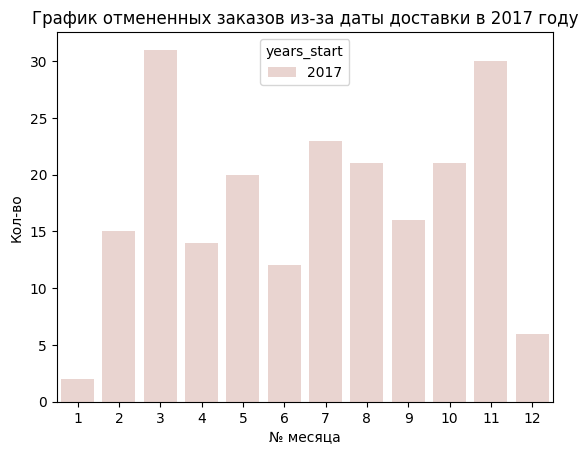

In [28]:
sns.countplot(x ='month_start', hue = "years_start", data = because_of_the_delivery_df.query('years_start == 2017')) \
    .set(title='График отмененных заказов из-за даты доставки в 2017 году', xlabel='№ месяца', ylabel='Кол-во')

- График заказов, где статус — недоступен в 2017 году.

[Text(0.5, 1.0, 'График заказов, где статус — недоступен в 2017 году'),
 Text(0.5, 0, '№ месяца'),
 Text(0, 0.5, 'Кол-во')]

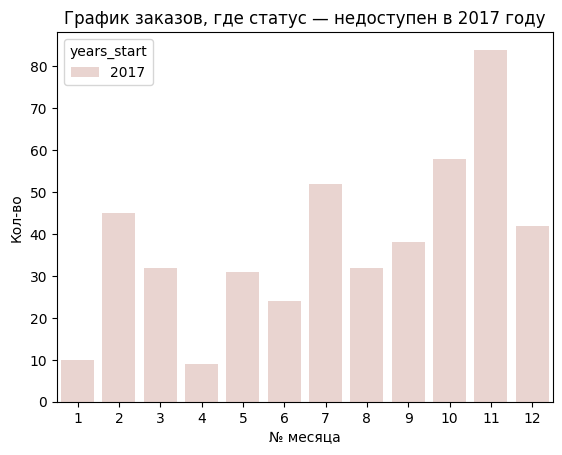

In [29]:
sns.countplot(x ='month_start', hue = "years_start", data = unavailable_df.query('years_start == 2017')) \
    .set(title='График заказов, где статус — недоступен в 2017 году', xlabel='№ месяца', ylabel='Кол-во')

- Считаем кол-во месяцев.

In [30]:
(count_orders_canceled_df.order_purchase_timestamp.max() - count_orders_canceled_df.order_purchase_timestamp.min()).days / 30

25.733333333333334

- Считаем сколько в среденм в месяц отменялось заказов по различнм причинам.

In [31]:
answer_2 = (141 + 484 + 609) / 26

In [32]:
np.round(answer_2, 1)

47.5

In [33]:
print('Ответ: в среднем', np.round(answer_2, 1), 'заказов в месяц не доставляется по разным причинам!')

Ответ: в среднем 47.5 заказов в месяц не доставляется по разным причинам!


### 3. По каждому товару определяем, в какой день недели товар чаще всего покупается. 

- Смотрим сколько уникальных товаров и их кол-во.

In [34]:
order_items_df['product_id'].value_counts()

product_id
aca2eb7d00ea1a7b8ebd4e68314663af    527
99a4788cb24856965c36a24e339b6058    488
422879e10f46682990de24d770e7f83d    484
389d119b48cf3043d311335e499d9c6b    392
368c6c730842d78016ad823897a372db    388
                                   ... 
dbc42f8ad8afd0147a5a46be630781f8      1
5d86ed92606c80a89e547cdba3946812      1
0b8750fa58fefe42cf03a9e2e4b8fce6      1
a4758e74e2cdb74d0c4db83594ca14a3      1
350688d9dc1e75ff97be326363655e01      1
Name: count, Length: 32951, dtype: int64

- Объединяем два дф, чтобы можно было сопоставить имя товара и дату его продажи.

In [35]:
orderes_df = order_items_df.merge(orders_df, on='order_id')

- Удаляем лишние колонки.

In [36]:
orderes_df = orderes_df.drop(['order_item_id', 'seller_id', 'shipping_limit_date', 'price'], axis=1)

In [37]:
orderes_df = orderes_df.drop(['freight_value', 'order_approved_at', 'order_delivered_carrier_date', \
    'order_delivered_customer_date', 'order_estimated_delivery_date'], axis=1)

- Приводит наш столбец с временем к нужному типу.

In [38]:
orderes_df['order_purchase_timestamp'] = pd.to_datetime(orderes_df['order_purchase_timestamp'])

- Создаем новый столбец с днями недели.

In [39]:
orderes_df['day_of_week'] = orderes_df['order_purchase_timestamp'].dt.day_name()

- Отбираем заказы только со статусом delivered. Объяснил в первом задании почему так. 

In [40]:
orderes_df = orderes_df.query('order_status == "delivered"')

In [41]:
orderes_df.head()

,order_id,product_id,customer_id,order_status,order_purchase_timestamp,day_of_week
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,Wednesday
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,Wednesday
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,Sunday
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,Wednesday
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,Saturday


- Cчитаем кол-во купленных товаров в определенный день недели.

In [42]:
orderes_df = orderes_df.groupby('product_id')['day_of_week'].value_counts().to_frame()

In [43]:
orderes_df.rename(columns={'day_of_week':'count'}, inplace=True)

In [44]:
orderes_df = orderes_df.reset_index()

In [45]:
orderes_df.head()

,product_id,day_of_week,count
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1


- Оставил только те дни недели, где у товара максимальное число покупок.

In [46]:
orderes_df = orderes_df.groupby(['product_id']).max().reset_index()
orderes_df.head()

,product_id,day_of_week,count
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Thursday,1
3,000b8f95fcb9e0096488278317764d19,Wednesday,1
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday,1


- Проверка на ункальность каждого товара.

In [47]:
orderes_df['product_id'].value_counts()

product_id
00066f42aeeb9f3007548bb9d3f33c38    1
ab9730d0380f2a4bb056dbed9417478a    1
abaefce0c17047c6829ff4078f2005d0    1
abad2a82d0a25653323cec918ba3e54c    1
abaa4c2633cbc40dda16b575531db57b    1
                                   ..
549356446db225e7f67b22ceaf66d159    1
5492f900418b499c9ea1479ebde6e1de    1
54919ddb6aa3bf5bf5901d504a8b7f18    1
54910b8287ecea5f93a008ebfa94a15c    1
fffe9eeff12fcbd74a2f2b007dde0c58    1
Name: count, Length: 32216, dtype: int64

- Визуализация по сумме купленных товаров в определенный день недели.

[Text(0.5, 1.0, 'График покупки товара, в какой день недели товар чаще всего покупается'),
 Text(0.5, 0, ''),
 Text(0, 0.5, 'Кол-во')]

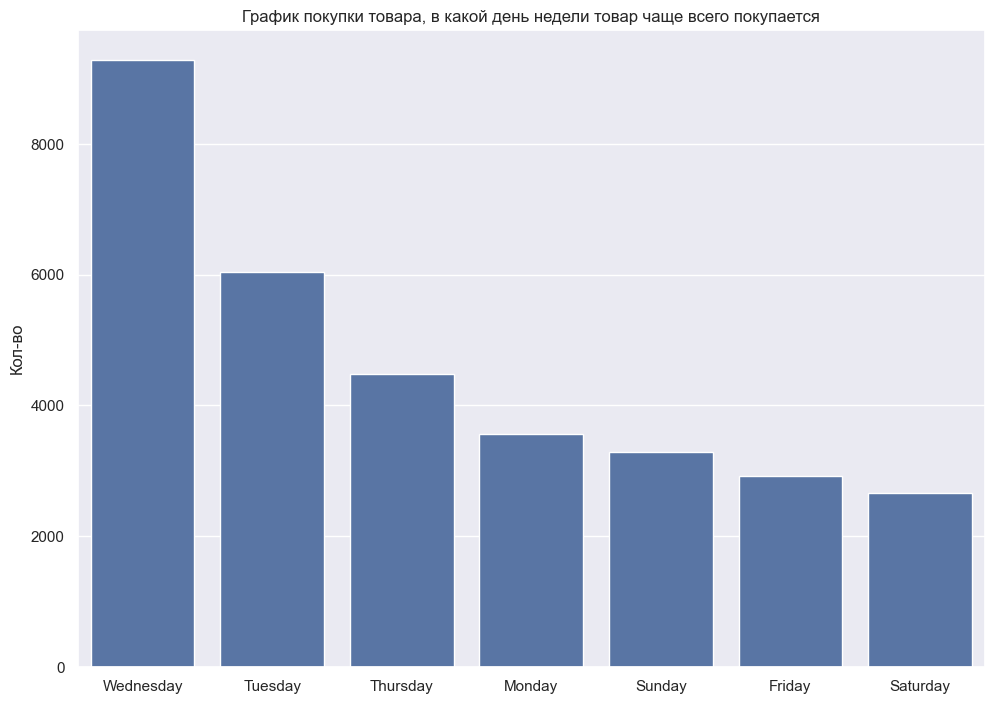

In [48]:
# Визуализация по сумме купленных товаров в определенный день недели.
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(x ='day_of_week', data = orderes_df, order=orderes_df['day_of_week'].value_counts().index) \
    .set(title='График покупки товара, в какой день недели товар чаще всего покупается', xlabel='', ylabel='Кол-во')

### 4. Считаем сколько у каждого из пользователей в среднем покупок в неделю (по месяцам). 

- Объединил все три датафрейма и определяем по-какому статусу он доставлен.

In [49]:
all_df = customer_unique_id_order_status.merge(order_items_df)
all_df = all_df.query('order_status == "delivered"')

- Привожу наши данные в нужный формат.

In [50]:
all_df['order_purchase_timestamp'] = pd.to_datetime(all_df['order_purchase_timestamp'])

In [51]:
all_df.dtypes

customer_id                              object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                        object
order_delivered_carrier_date             object
order_delivered_customer_date            object
order_estimated_delivery_date            object
order_item_id                             int64
product_id                               object
seller_id                                object
shipping_limit_date                      object
price                                   float64
freight_value                           float64
dtype: object

- Считаю кол-во дней в месяце используя метод days_in_month

In [52]:
all_df['count_of_days'] = all_df.order_purchase_timestamp.dt.days_in_month

In [53]:
all_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,count_of_days
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88,31
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48,31
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79,31
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36,31
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25,31


- Группирую по нужным столбцам.

In [54]:
all_df = all_df.groupby(['customer_unique_id', 'order_purchase_timestamp', 'count_of_days'], as_index=False) \
    .agg({'customer_state':'count'}) \
    .rename(columns={'customer_unique_id':'id', 'order_purchase_timestamp':'data', 'customer_state': 'count_of_purchases'})

- Считаю кол-во недель в месяце.

In [55]:
all_df['weeks_in_a_month'] = all_df.count_of_days / 7

In [56]:
all_df.head()

,id,data,count_of_days,count_of_purchases,weeks_in_a_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,31,1,4.428571
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,31,1,4.428571
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,31,1,4.428571
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,31,1,4.428571
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,30,1,4.285714


- Покупок в неделю по месяцам — 2PWBM(Purchases per week by month).

In [57]:
all_df['2PWBM'] = all_df.count_of_purchases / all_df.weeks_in_a_month

In [58]:
all_df.head()

,id,data,count_of_days,count_of_purchases,weeks_in_a_month,2PWBM
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,31,1,4.428571,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,31,1,4.428571,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,31,1,4.428571,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,31,1,4.428571,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,30,1,4.285714,0.233333


### 5. Выполните когортный анализ пользователей.

In [59]:
cohorts_df = customers_df.merge(orders_df, on='customer_id')

- Преобразуем наши данные.

In [60]:
cohorts_df = cohorts_df.dropna(axis='index', how='any', subset=['order_approved_at'])

cohorts_df = cohorts_df.drop(['customer_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state'], axis=1)
cohorts_df = cohorts_df.drop(['order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'], axis=1)

cohorts_df['order_approved_at'] = pd.to_datetime(cohorts_df['order_approved_at'])

 Воспользуемся очень удобной функцией transform() совместно с groupby(), которая позволяет применять встроенные функции
 или пользовательске функции. Данная функция поможет показать нам первые покупки пользователя на нашем сайте.

In [61]:
cohorts_df['the_first_purchase'] = cohorts_df.groupby('customer_unique_id')['order_approved_at'].transform('min')

In [62]:
cohorts_df.head()

,customer_unique_id,order_id,order_status,order_purchase_timestamp,order_approved_at,the_first_purchase
0,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-16 15:22:12
1,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-12 20:58:32
2,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-05-20 16:19:10
3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-13 17:29:19
4,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-29 10:10:09


- Приводим данные в нужный формат.

In [63]:
cohorts_df['order_approved_at'] = cohorts_df['order_approved_at'].dt.to_period('M')
cohorts_df['the_first_purchase'] = cohorts_df['the_first_purchase'].dt.to_period('M')

- Для анализа возьмем только 2017 год, т.к только тут достаточно данных для проведения когортного анализа.

In [64]:
cohorts_df = cohorts_df.query("'2017-01' <= the_first_purchase <= '2017-12'")
cohorts_df = cohorts_df.query("'2017-01' <= order_approved_at <= '2017-12'")

- Считаем кол-во месяцев без покупок.

In [65]:
cohorts_df['month_passed'] = (cohorts_df['order_approved_at'] - cohorts_df['the_first_purchase']).apply(lambda x: x.n)

- Группируем наши данные по первому заказу и пропущенному месяцу.

In [66]:
cohorts_df = cohorts_df.query('order_status == "delivered"') \
    .groupby(['the_first_purchase', 'month_passed'], as_index=False) \
    .agg({"customer_unique_id": "nunique"}) \
    .rename(columns={'customer_unique_id': 'count_unq_id'})

- Меняем структуру таблицы.

In [67]:
cohorts_df = cohorts_df.pivot_table(index = 'the_first_purchase', columns = 'month_passed', values = 'count_unq_id')

- Сохраним столбец с первыми значениями.

In [68]:
first = cohorts_df.iloc[:,0]

- Убираем элементы на 0, которые выше побочной диагонали и пустые.

In [69]:
def replace_values(matrix):
    '''
    Принимает матрицу и заменяет все элементы на 0,
    которые выше побочной диагонали и пустые.
    '''
    size = len(matrix)
    for i in range(size):
        for j in range(size):
            if i + j < len(matrix) - 1 and np.isnan(matrix.iloc[i,j]) == True:
                matrix.iloc[i,j] = 0
    return matrix

- Построим когортную таблицу.

In [70]:
result = cohorts_df.div(first, axis = 0) * 100

In [71]:
ur_style = (replace_values(result).iloc[:, 1:] 
            #используем нашу ф-ю replace_values и берем все столбы кроме 1-го
            .style
            .set_caption('User retention by cohort in 2017')
            .background_gradient(cmap='viridis') 
            .highlight_null('white')  
            .format("{:.2%}", na_rep=""))  

ur_style

month_passed,1,2,3,4,5,6,7,8,9,10,11
the_first_purchase,,,,,,,,,,,
2017-01,58.57%,29.28%,14.64%,43.92%,14.64%,43.92%,14.64%,14.64%,0.00%,29.28%,29.28%
2017-02,24.83%,24.83%,18.62%,43.45%,12.41%,24.83%,18.62%,12.41%,24.83%,12.41%,
2017-03,51.79%,35.86%,35.86%,35.86%,15.94%,15.94%,31.87%,31.87%,11.95%,,
2017-04,62.78%,22.42%,17.94%,26.91%,26.91%,35.87%,26.91%,35.87%,,,
2017-05,55.02%,52.13%,37.65%,31.86%,34.75%,43.44%,17.38%,,,,
2017-06,49.29%,36.15%,39.43%,26.29%,32.86%,39.43%,,,,,
2017-07,53.95%,35.07%,21.58%,35.07%,18.88%,,,,,,
2017-08,68.66%,36.78%,26.97%,36.78%,,,,,,,
2017-09,67.10%,49.70%,32.31%,,,,,,,,


### 6. Построю RFM-сегментацию пользователей, чтобы качественно оценить аудиторию, R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время.

- Создаем дф, группируем и приводим к нужному формату наши данные.

In [72]:
RFM = customer_unique_id_order_status.merge(order_items_df)
RFM = RFM.query("order_status == 'delivered'").groupby(['order_id', 'customer_unique_id', 'order_approved_at'], as_index=False).agg({'price': 'sum'})

In [73]:
RFM['order_approved_at'] = pd.to_datetime(RFM.order_approved_at)

In [74]:
RFM.head()

,order_id,customer_unique_id,order_approved_at,price
0,00010242fe8c5a6d1ba2dd792cb16214,871766c5855e863f6eccc05f988b23cb,2017-09-13 09:45:35,58.90
1,00018f77f2f0320c557190d7a144bdd3,eb28e67c4c0b83846050ddfb8a35d051,2017-04-26 11:05:13,239.90
2,000229ec398224ef6ca0657da4fc703e,3818d81c6709e39d06b2738a8d3a2474,2018-01-14 14:48:30,199.00
3,00024acbcdf0a6daa1e931b038114c75,af861d436cfc08b2c2ddefd0ba074622,2018-08-08 10:10:18,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,64b576fb70d441e8f1b2d7d446e483c5,2017-02-04 14:10:13,199.90


- Считаем Recency.

In [75]:
current_date = datetime.today()
RFM['recency'] = RFM.order_approved_at.apply(lambda x: current_date - x).dt.days

- Группируем по customer_unique_id, возьмем минимальный Recency(это и есть время от последней покупки пользователя), считаем Freqency и Monetary.

In [76]:
RFM = RFM.groupby('customer_unique_id', as_index=False).agg({'recency':'min', 'order_id':'nunique', 'price':'sum'}).rename(columns={'order_id':'freqency', 'price':'monetary'})
RFM.head()

,customer_unique_id,recency,freqency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,2174,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2176,1,18.90
2,0000f46a3911fa3c0805444483337064,2599,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,2383,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,2350,1,180.00


- Посмотрим на наши данные.

In [77]:
 RFM.describe()

,recency,freqency,monetary
count,93345.000000,93345.000000,93345.000000
mean,2299.319171,1.033414,141.623308
std,152.569395,0.209088,215.705007
min,2062.000000,1.000000,0.850000
25%,2176.000000,1.000000,47.650000
50%,2280.000000,1.000000,89.760000
75%,2407.000000,1.000000,154.750000
max,2775.000000,15.000000,13440.000000


<Axes: xlabel='recency', ylabel='Count'>

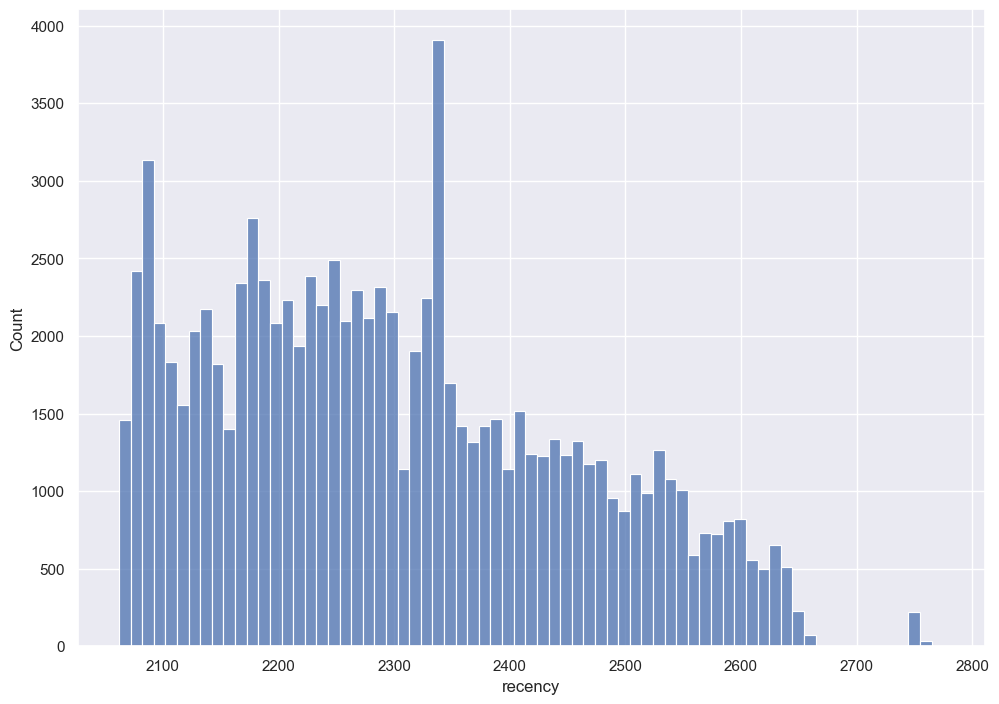

In [78]:
sns.histplot(RFM.recency)

<Axes: xlabel='freqency', ylabel='Count'>

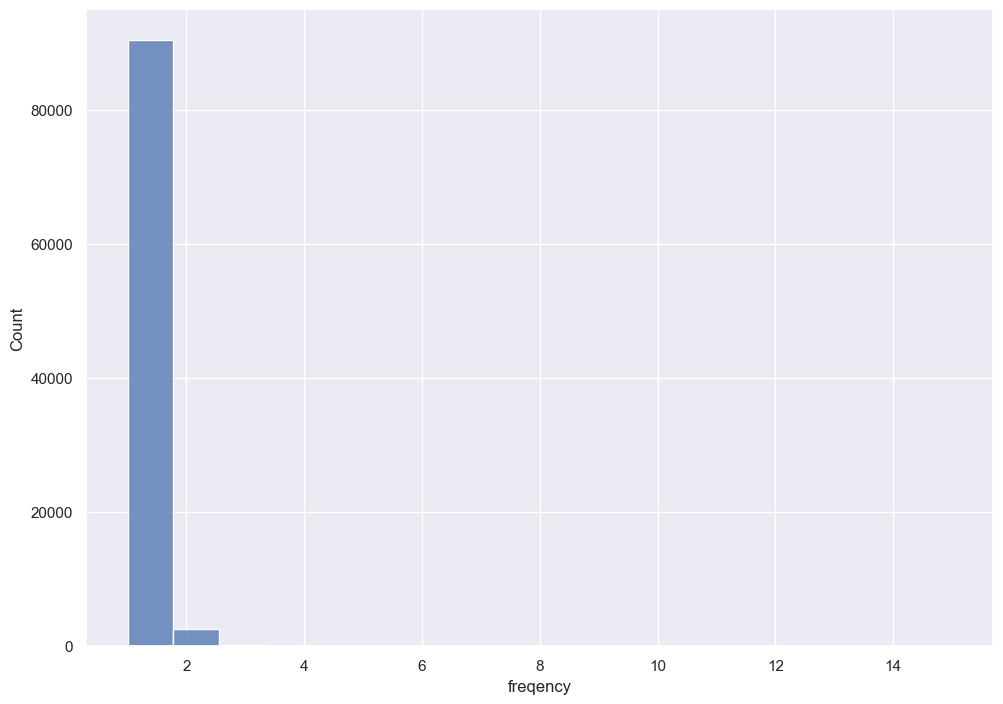

In [79]:
sns.histplot(RFM.freqency)

<Axes: xlabel='monetary', ylabel='Count'>

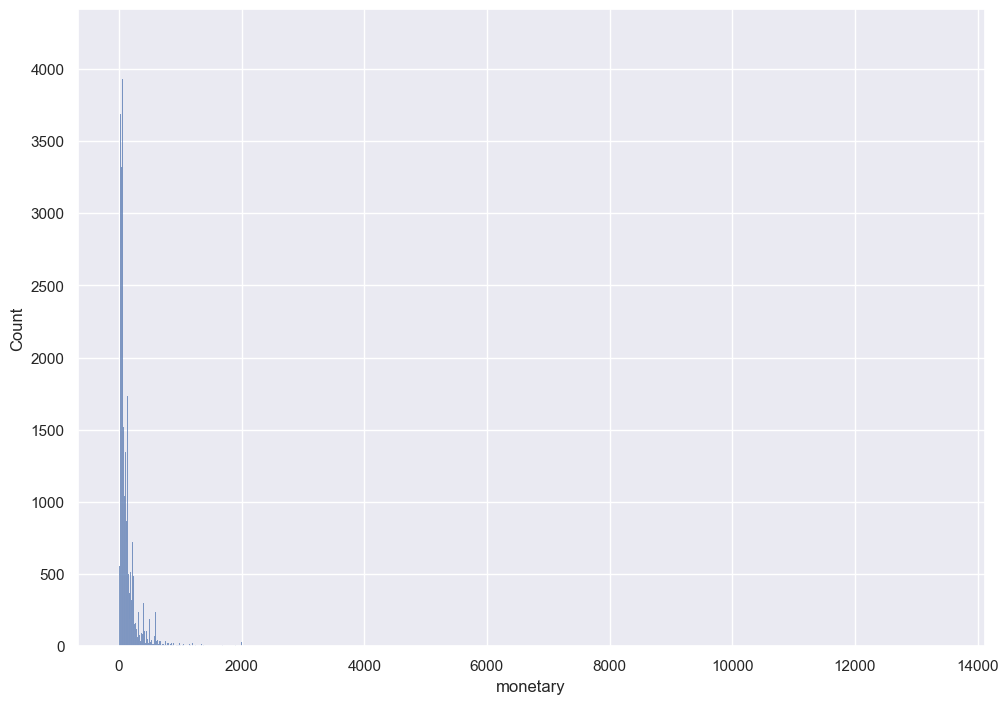

In [80]:
sns.histplot(RFM.monetary)

- Т.к большенство пользователей сделало по одному заказу, то будет распределять на две группы 1 — 1 заказ, 2 — больше одного. Подобным образом сделаем с recency, будем делить по медианному значению 2298.8, и с monetary сделаем аналогично, поделим на две группы по квантилю q=.96, который = 499.5.

- Функции для разделения RFM на сигменты.

In [81]:
def seg_R(x):
    if x <= RFM.recency.median():
        return 1
    else:
        return 2

In [82]:
 def seg_F(x):
    if x > 1:
        return 1
    else:
        return 2

In [83]:
def seg_M(x):
    if x >=  RFM.monetary.quantile(q=0.96):
        return 1
    else:
        return 2

- Делим на сигменты.

In [84]:
RFM['R'] = RFM['recency'].apply(lambda x: seg_R(x))
RFM['F'] = RFM['freqency'].apply(lambda x: seg_F(x))
RFM['M'] = RFM['monetary'].apply(lambda x: seg_M(x))
RFM['RFM'] = RFM['R'].map(str) + RFM['F'].map(str) + RFM['M'].map(str)

In [85]:
RFM.head()

,customer_unique_id,recency,freqency,monetary,R,F,M,RFM
0,0000366f3b9a7992bf8c76cfdf3221e2,2174,1,129.90,1,2,2,122
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2176,1,18.90,1,2,2,122
2,0000f46a3911fa3c0805444483337064,2599,1,69.00,2,2,2,222
3,0000f6ccb0745a6a4b88665a16c9f078,2383,1,25.99,2,2,2,222
4,0004aac84e0df4da2b147fca70cf8255,2350,1,180.00,2,2,2,222


- Считаем кол-во пользователей в каждом сегменте.

In [86]:
RFM_GB = RFM.groupby('RFM', as_index=False).agg({'customer_unique_id':'count'}).rename(columns={'customer_unique_id':'count'})
RFM_GB

,RFM,count
0,111,164
1,112,1378
2,121,1730
3,122,43421
4,211,119
5,212,1139
6,221,1721
7,222,43673


<Axes: xlabel='RFM', ylabel='count'>

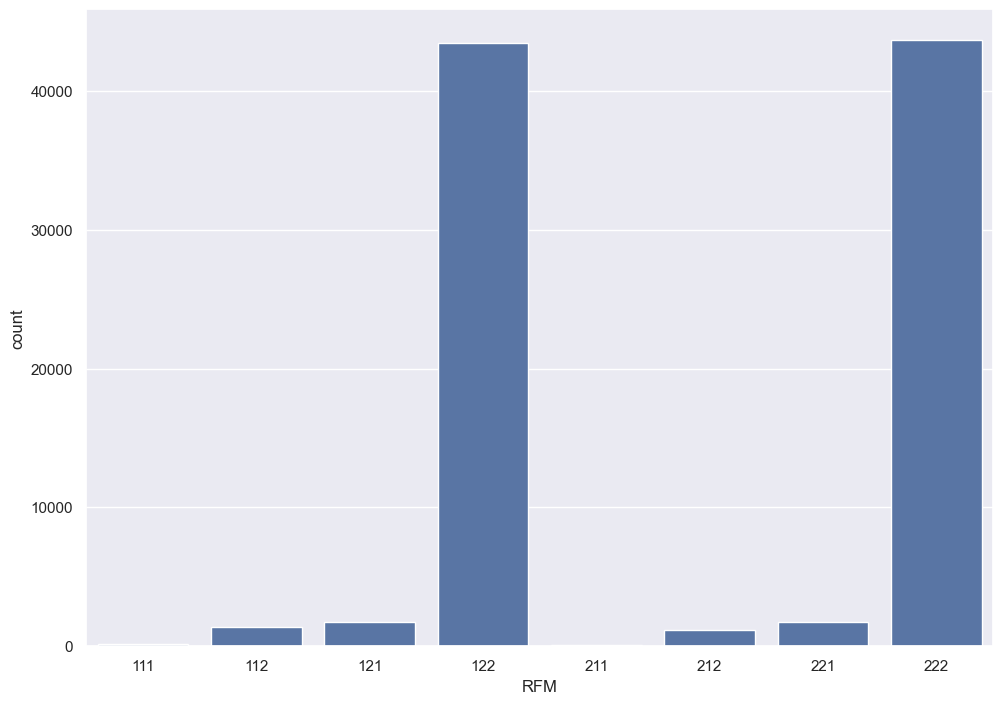

In [87]:
 sns.barplot(data=RFM_GB, x='RFM', y='count')

- Сделаем наименование групп.

In [88]:
customer_types = {
    '111': '+R',
    '211': '+R',
    '112': '+F',
    '212': '+F',
    '121': '+M',
    '221': '+M',
    '122': '—',
    '222': '—'
}

In [89]:
RFM_GB['type'] = RFM_GB['RFM'].map(customer_types)

<Axes: xlabel='type', ylabel='count'>

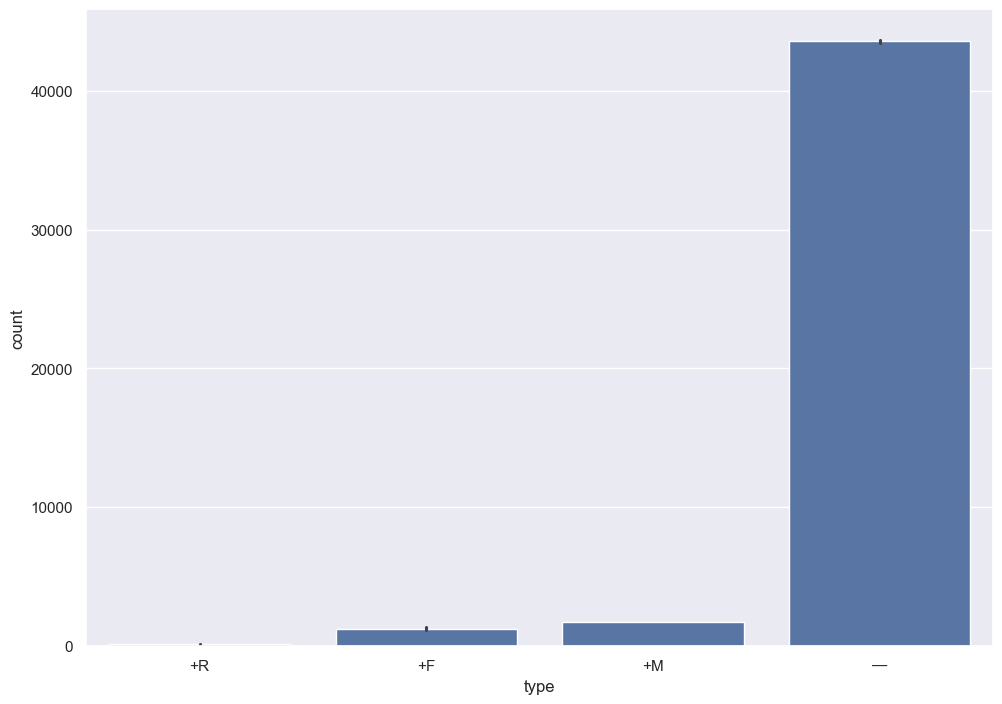

In [90]:
 sns.barplot(data=RFM_GB, x='type', y='count')